Time for training:  9.201e-02
Anomaly detection ratio:  1.505e-03


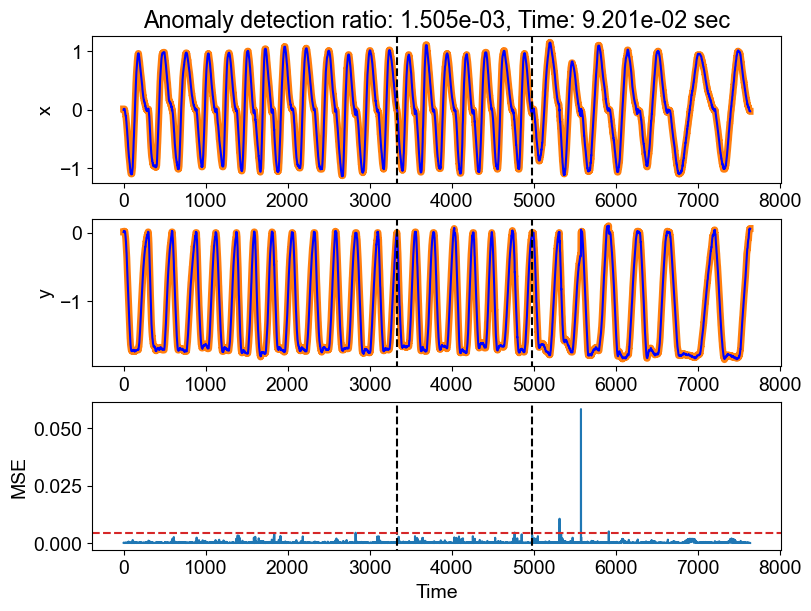

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

########################################
# ESN-based anomaly detection for handwritten triangle data
#
# The model is trained with a part of InoueI data, validated with 
# the remaining data from InoueI, and then tested with InoueH data.
#
# (c) Gouhei Tanaka
########################################

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from scipy import optimize
from model import ESN, Tikhonov, Pseudoinv

if __name__ == '__main__':

    # read data (InoueI)
    data_i = np.empty([0,3])
    count_i = 0
    for n in range(7):
        df = pd.read_csv('./InoueI/inouei_'+str(n)+'.csv', header=0, delimiter=',')
        #print(df.shape)
        count_i += df.shape[0]
        #print(count_i)
        data_i = np.vstack((data_i, df))
    #print('isao')
    #print(data_i)
    #print(data_i.shape)

    data_i_x = data_i[:,1]/100
    data_i_x = data_i_x.reshape(len(data_i_x), -1)
    data_i_y = data_i[:,2]/100
    data_i_y = data_i_y.reshape(len(data_i_y), -1)

    #scaler = StandardScaler()
    #std_data_i_x = scaler.fit_transform(data_i_x)
    #std_data_i_y = scaler.fit_transform(data_i_y)

    # read data (InoueH)
    data_h = np.empty([0,3])
    count_h = 0
    for n in range(20):
        df = pd.read_csv('./InoueH/inoueH_'+str(n)+'.csv', header=0, delimiter=',')
        #print(df.shape)
        count_h += df.shape[0]
        #print(count_h)
        data_h = np.vstack((data_h, df))
    #print('hisashi')
    #print(data_h)
    #print(data_h.shape)

    data_h_x = data_h[:,1]/100
    data_h_x = data_h_x.reshape(len(data_h_x), -1)
    data_h_y = data_h[:,2]/100
    data_h_y = data_h_y.reshape(len(data_h_y), -1)

    # data scaling
    '''
    scaler = StandardScaler()
    std_data_h_x = scaler.fit_transform(data_h_x)
    std_data_h_y = scaler.fit_transform(data_h_y)
    '''
    
    # concatenate two data without scaling
    data_x = np.concatenate((data_h_x, data_i_x))
    data_y = np.concatenate((data_h_y, data_i_y))
    data = np.hstack([data_x, data_y])
    
    # train, validation, test data length
    pred_len = 1 # one-step-ahead prediction
    len_train = 3333-pred_len
    len_val = count_h-3333
    len_test = data.shape[0]-len_train-len_val

    # input data U and target data D
    U_train = data[0:len_train,:]
    U_val = data[len_train:len_train+len_val:]
    U_test = data[len_train+len_val:len_train+len_val+len_test,:]
    D_train = data[pred_len:len_train+pred_len,:]
    D_val = data[len_train+pred_len:len_train+len_val+pred_len,:]
    D_test = data[len_train+len_val+pred_len:len_train+len_val+len_test+pred_len,:]

    D = np.vstack((D_train, D_val))
    D = np.vstack((D, D_test))
    
    '''
    print(U_train.shape)
    print(U_val.shape)
    print(U_test.shape)
    print(D_train.shape)
    print(D_val.shape)
    print(D_test.shape)
    '''
    
    # ESN model
    N_x = 20  # reservoir size
    model = ESN(U_train.shape[1], D_train.shape[1], N_x, density=0.05, input_scale=1.0, rho=0.9)
    
    # training
    time_start = time.time()
    model.train(U_train, D_train, Tikhonov(N_x, D_train.shape[1], 1e-5))
    #model.train(U_train, D_train, Pseudoinv(N_x, D_train.shape[1]))
    time_end = time.time()
    time_learning = time_end-time_start
    time_learning = '{0:.3e}'.format(time_learning)
    print('Time for training: ', time_learning)
    
    # model outputs
    Y_train = model.predict(U_train)
    Y_val = model.predict(U_val)
    Y_test = model.predict(U_test)
    Y = np.vstack((Y_train, Y_val))
    Y = np.vstack((Y, Y_test))
    #print(Y)

    # error evaluation
    mse_all = []
    rmse_all = []
    mae_all = []
    for i in range(D.shape[0]):
        mse = ((D[i,0] - Y[i,0])**2+(D[i,1]-Y[i,1])**2)/2
        mse_all.append(mse)
        rmse_all.append(np.sqrt(mse))
        mae_all.append(np.abs(D[i,0] - Y[i,0]))


    mse_val = []
    rmse_val = []
    mae_val = []
    mse_val_max = 0.0
    for i in range(D_val.shape[0]):
        mse = ((D_val[i,0] - Y_val[i,0])**2+(D_val[i,1]-Y_val[i,1])**2)/2
        mse_val.append(mse)
        rmse_val.append(np.sqrt(mse))
        mae_val.append(np.abs(D_val[i,0] - Y_val[i,0]))
        if mse > mse_val_max:
            mse_val_max = mse
            #print(i, mse_val_max)

    mse_test = []
    rmse_test = []
    mae_test = []
    count_a = 0
    for i in range(D_test.shape[0]):
        mse = ((D_test[i,0] - Y_test[i,0])**2+(D_test[i,1]-Y_test[i,1])**2)/2
        mse_test.append(mse)
        rmse_test.append(np.sqrt(mse))
        mae_test.append(np.abs(D_test[i,0] - Y_test[i,0]))
        if mse >= mse_val_max:
            count_a += 1
    adr = count_a/D_test.shape[0]
    adr = '{0:.3e}'.format(adr)
    print('Anomaly detection ratio: ', adr)
    
    # draw
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(3, 1, figsize=(8,6), constrained_layout=True)
    #plt.subplots_adjust(hspace=0.2)

    ax[0].plot(D[:,0], color='tab:orange', linewidth=5, label = 'Target')
    ax[0].plot(Y[:,0], color='blue', label = 'Prediction')
    ax[0].axvline(x=len_train, ymin=-1, ymax=1, linestyle='--', color='black')
    ax[0].axvline(x=len_train+len_val, ymin=-1, ymax=1, linestyle='--', color='black')
    ax[0].set_ylabel('x')
    ax[0].set_title('Anomaly detection ratio: '+str(adr)+', Time: '+str(time_learning)+' sec')
    #ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #ax[0].legend(loc='best')

    ax[1].plot(D[:,1], color='tab:orange', linewidth=5, label = 'Target')
    ax[1].plot(Y[:,1], color='blue', label = 'Prediction')
    ax[1].axvline(x=len_train, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[1].axvline(x=len_train+len_val, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[1].set_ylabel('y')
    #ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    #ax[1].legend(loc='best')

    ax[2].plot(mse_all, '-')
    #ax[2].plot(mae_all, label='MAE')
    #ax[2].plot(rmse_all, label='RMSE')
    ax[2].set_ylabel('MSE')
    #ax[2].set_ylim([0, 0.02])
    ax[2].axvline(x=len_train, ymin=-2, ymax=1, linestyle='--', color='black')
    ax[2].axvline(x=len_train+len_val, ymin=-2, ymax=1, linestyle='--', color='black')
    #ax[2].axvline(x=3333+1390, ymin=-2, ymax=1, linestyle='--', color='tab:pink')
    ax[2].axhline(y=mse_val_max, xmin=0, xmax=D.shape[0], linestyle='--', color='tab:red')
    ax[2].set_xlabel('Time')

    plt.show()